# Imports And Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import yaml

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [4]:
df = "/kaggle/input/multi-class-object-detection-challenge"

metadata = {
    "train" : f"{df}/Starter_Dataset/train/images",
    "val" : f"{df}/Starter_Dataset/val/images",
    "test" : f"{df}/testImages/images",
    "nc" : 2,
    "names" : ["cheerios", "soup"]
}

with open("metadata.yaml", "w") as file:
    yaml.dump(metadata, file)

In [5]:
train_imgs = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/images"
train_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/labels"
val_imgs = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/images"
val_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels"

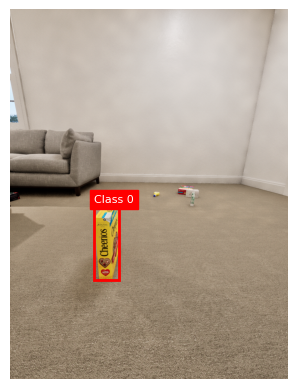

In [6]:
for label_file in os.listdir(train_labels):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        lines = f.readlines()
        if not any(line.startswith("0") for line in lines):
            continue

    img_name = label_file.replace(".txt", ".png")
    img_path = os.path.join(train_imgs, img_name)

    if not os.path.exists(img_path):
        continue

    img = plt.imread(img_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        if int(cls) != 0:
            continue

        img_h, img_w = img.shape[:2]
        x1 = (x - w/2) * img_w
        y1 = (y - h/2) * img_h
        box_w = w * img_w
        box_h = h * img_h

        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"Class {int(cls)}", color='white', backgroundcolor='red', fontsize=8)

    plt.axis('off')
    plt.show()
    break  # remove this line to display all such images

In [7]:
train_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/labels"
val_labels = "/kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels"

def count_classes(label_path):
    c0 = c1 = 0
    for file in os.listdir(label_path):
        if not file.endswith('.txt'):
            continue
        with open(os.path.join(label_path, file), 'r') as f:
            for line in f:
                cls = line.strip().split()[0]
                if cls == '0': c0 += 1
                elif cls == '1': c1 += 1
    return c0, c1

t0, t1 = count_classes(train_labels)
v0, v1 = count_classes(val_labels)

print(f"Train images: {len(os.listdir(train_imgs))}")
print(f"Train: {t0} Cheerios, {t1} Soup")
print(f"Val images: {len(os.listdir(val_imgs))}")
print(f"Val: {v0} Cheerios, {v1} Soup")

Train images: 1000
Train: 565 Cheerios, 594 Soup
Val images: 95
Val: 88 Cheerios, 84 Soup


# Training The Model

In [8]:
from ultralytics import YOLO

model = YOLO('yolo11x.pt')
metadata = "/kaggle/working/metadata.yaml"

model.train(
    data = metadata,    # yaml configuration file
    epochs = 50,        
    # time = 0.083,
    # patience = 5,
    batch = 4,
    imgsz = 512,
    save = True,
    save_period = 5,   # Frequency of saving interim models
    device = 'cuda', # For GPU
    workers = 4,     # Number of worker threads
    project="/kaggle/working",    # project dir
    exist_ok = True,    # overwrite current model
    optimizer = "AdamW",    # optimizer method
    seed = 12,    # seed for reproducibility
    multi_scale = True,    # scaling pictures
    cos_lr = True,   # cosine learning rate scheduler to move from lr0 to lrf
    close_mosaic = 10,   # disable mosaic data augmentation
    # resume = True,
    lr0 = 0.001,    # initial learning rate
    lrf = 0.0001,   # final learning rate
    weight_decay = 0.0005,    # regularization
    warmup_epochs = 5,    # warmup for lr0
    # dropout = 0.4,
    plots = True,   # save plots of metrics

    hsv_h = 0.5,   # hue
    hsv_s = 0.5,   # saturation
    hsv_v = 0.5,   # brightness
    degrees = 10,  # rotation
    translate = 0.1,   # translation
    scale = 0.2,   # scaling
    shear = 10,    # shear
    perspective = 0.001,   # random perspective transformation
    flipud = 0.1,   # probability of flipping image vertically
    fliplr = 0.5,   # probability of flipping image horizontally
    bgr = 0.01,
    # mixup = 0.02,
    # cutmix = 0.01,
    # erasing = 0.1
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 109M/109M [00:01<00:00, 79.2MB/s] 


Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.01, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/metadata.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.5, hsv_s=0.5, hsv_v=0.5, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=True, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.001, plots=True, pose=12.0, 

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 82.7±66.8 MB/s, size: 5235.0 KB)


train: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train/labels... 1000 images, 57 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:14<00:00, 70.66it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 165.9±17.4 MB/s, size: 11532.5 KB)


val: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels... 95 images, 2 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:03<00:00, 29.29it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val is not writeable, cache not saved.


Plotting labels to /kaggle/working/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 4 dataloader workers
Logging results to /kaggle/working/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.31G      1.437      1.834      1.455         10        384: 100%|██████████| 250/250 [01:49<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


                   all         95        172      0.359      0.265      0.266      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.44G       1.49      1.478      1.509         11        544: 100%|██████████| 250/250 [01:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.314      0.384       0.32      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.57G      1.495       1.57      1.514         15        672: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.357      0.399      0.296      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.71G      1.501      1.549      1.479          5        672: 100%|██████████| 250/250 [01:37<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.669      0.392      0.482      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.84G      1.469       1.57      1.517          8        352: 100%|██████████| 250/250 [01:45<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.661      0.196      0.251      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.45G      1.467      1.443      1.484          5        384: 100%|██████████| 250/250 [01:38<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.527      0.485       0.46      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.38G      1.414       1.35      1.437          6        320: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


                   all         95        172      0.409      0.328      0.211      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.64G      1.396      1.317      1.446         10        544: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.39it/s]


                   all         95        172      0.675      0.366      0.444      0.236

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.77G       1.38       1.28      1.416          7        704: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]

                   all         95        172      0.623      0.353        0.3      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.45G      1.387      1.326      1.416         12        704: 100%|██████████| 250/250 [01:40<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]


                   all         95        172      0.628      0.491      0.497      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.82G      1.342      1.205      1.397          7        544: 100%|██████████| 250/250 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.654      0.479      0.521      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.95G      1.299      1.174      1.359         11        448: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]

                   all         95        172      0.592       0.47      0.496      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.42G      1.312       1.15       1.39         12        768: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]

                   all         95        172        0.6      0.362      0.392      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.55G      1.305      1.149      1.361          6        640: 100%|██████████| 250/250 [01:42<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

                   all         95        172      0.685      0.366      0.391       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.69G      1.263      1.085      1.362          5        416: 100%|██████████| 250/250 [01:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

                   all         95        172      0.723      0.531      0.607      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.81G      1.294      1.082      1.352          9        576: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


                   all         95        172      0.731      0.348      0.367      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.43G      1.269      1.062      1.335          9        576: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.658      0.527      0.562      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.22G      1.247      1.003      1.356          5        736: 100%|██████████| 250/250 [01:44<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.817      0.527      0.602      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.35G      1.266      1.032      1.368         13        480: 100%|██████████| 250/250 [01:42<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.545      0.425      0.456       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.48G      1.241     0.9789      1.349          6        448: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

                   all         95        172      0.681       0.48      0.519      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.09G      1.252     0.9877       1.32          8        320: 100%|██████████| 250/250 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.747      0.504        0.6      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.38G      1.253     0.9745      1.325          3        768: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

                   all         95        172      0.834      0.438      0.579      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.51G      1.221     0.9257      1.318          9        544: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]

                   all         95        172      0.736      0.508      0.557      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.64G      1.175     0.9247      1.301         10        608: 100%|██████████| 250/250 [01:37<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.38it/s]

                   all         95        172      0.795      0.409      0.454      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.77G       1.19     0.8699      1.293         10        384: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]

                   all         95        172      0.818      0.574      0.658        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       7.9G      1.199     0.8608      1.313         10        288: 100%|██████████| 250/250 [01:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


                   all         95        172      0.626      0.436      0.481      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.35G       1.21      0.854      1.297          9        288: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.801       0.44      0.593       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.34G      1.168     0.8269      1.281          6        576: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all         95        172      0.853      0.532       0.63      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.47G      1.165     0.8113      1.295          5        512: 100%|██████████| 250/250 [01:41<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.53it/s]

                   all         95        172      0.797      0.508      0.582      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       7.6G      1.135     0.7844      1.253          7        544: 100%|██████████| 250/250 [01:34<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


                   all         95        172       0.77      0.486       0.58       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.21G      1.131     0.7832      1.251         11        576: 100%|██████████| 250/250 [01:38<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

                   all         95        172      0.824        0.5      0.598       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.31G      1.147     0.7479      1.246          7        480: 100%|██████████| 250/250 [01:35<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]

                   all         95        172      0.824      0.476      0.581      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.44G      1.148      0.734      1.258          6        320: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.847       0.63      0.692      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.58G      1.135     0.7464      1.257          7        256: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]

                   all         95        172      0.833      0.655      0.737      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.19G      1.109     0.7164      1.259          9        416: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all         95        172      0.861      0.634      0.733      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.53G      1.094      0.694      1.256          6        736: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


                   all         95        172      0.849      0.639      0.749      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      7.66G      1.081     0.7106      1.236          5        640: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

                   all         95        172      0.845      0.613      0.698       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.79G      1.077     0.7113      1.217          8        288: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.854      0.581      0.684      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.92G      1.091      0.662      1.219          8        288: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.861      0.542      0.636      0.414


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.05G     0.9685     0.5611      1.174          3        416: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]

                   all         95        172      0.818      0.598      0.666      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.57G     0.9733     0.5288      1.171          4        256: 100%|██████████| 250/250 [01:39<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.814      0.607      0.694      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       7.7G     0.9633     0.5447      1.165          4        544: 100%|██████████| 250/250 [01:41<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


                   all         95        172      0.753      0.649      0.708      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      7.83G     0.9737     0.5029      1.183          5        576: 100%|██████████| 250/250 [01:39<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]

                   all         95        172      0.782      0.547      0.645      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      7.96G     0.9605     0.5242      1.145          3        768: 100%|██████████| 250/250 [01:40<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]

                   all         95        172      0.795       0.58      0.674      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      7.65G     0.9396     0.5039      1.124          4        608: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]

                   all         95        172      0.841      0.551      0.681      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      7.79G     0.9502     0.4977      1.143          4        672: 100%|██████████| 250/250 [01:37<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]

                   all         95        172      0.823      0.558      0.667      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.92G     0.9355     0.4907      1.155          5        352: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]

                   all         95        172      0.825      0.541      0.675      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.05G     0.9515     0.4945      1.149          4        544: 100%|██████████| 250/250 [01:39<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.40it/s]

                   all         95        172      0.824      0.536      0.676      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.25G     0.9481     0.4919      1.151          5        480: 100%|██████████| 250/250 [01:36<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]

                   all         95        172      0.863      0.526      0.671      0.442



50 epochs completed in 1.545 hours.
Optimizer stripped from /kaggle/working/train/weights/last.pt, 114.4MB
Optimizer stripped from /kaggle/working/train/weights/best.pt, 114.4MB

Validating /kaggle/working/train/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         95        172       0.85      0.639      0.749      0.489
              cheerios         88         88       0.79      0.682       0.77      0.486
                  soup         84         84      0.909      0.595      0.728      0.491
Speed: 0.1ms preprocess, 18.5ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7acd564a90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [23]:
model = YOLO("/kaggle/working/train/weights/best.pt") 
metrics = model.val(data="/kaggle/working/metadata.yaml", imgsz=512, save=True, save_txt=True, save_conf=True, save_hybrid=True,) 

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.4 ms, read: 3053.1±671.6 MB/s, size: 17932.1 KB)


val: Scanning /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val/labels... 95 images, 2 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:01<00:00, 70.54it/s] 

WARNING ⚠️ val: Cache directory /kaggle/input/multi-class-object-detection-challenge/Starter_Dataset/val is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:19<00:00,  3.22s/it]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         95        172      0.857      0.644       0.75      0.491
              cheerios         88         88      0.788      0.682      0.772      0.486
                  soup         84         84      0.927      0.607      0.728      0.496
Speed: 0.1ms preprocess, 17.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val4


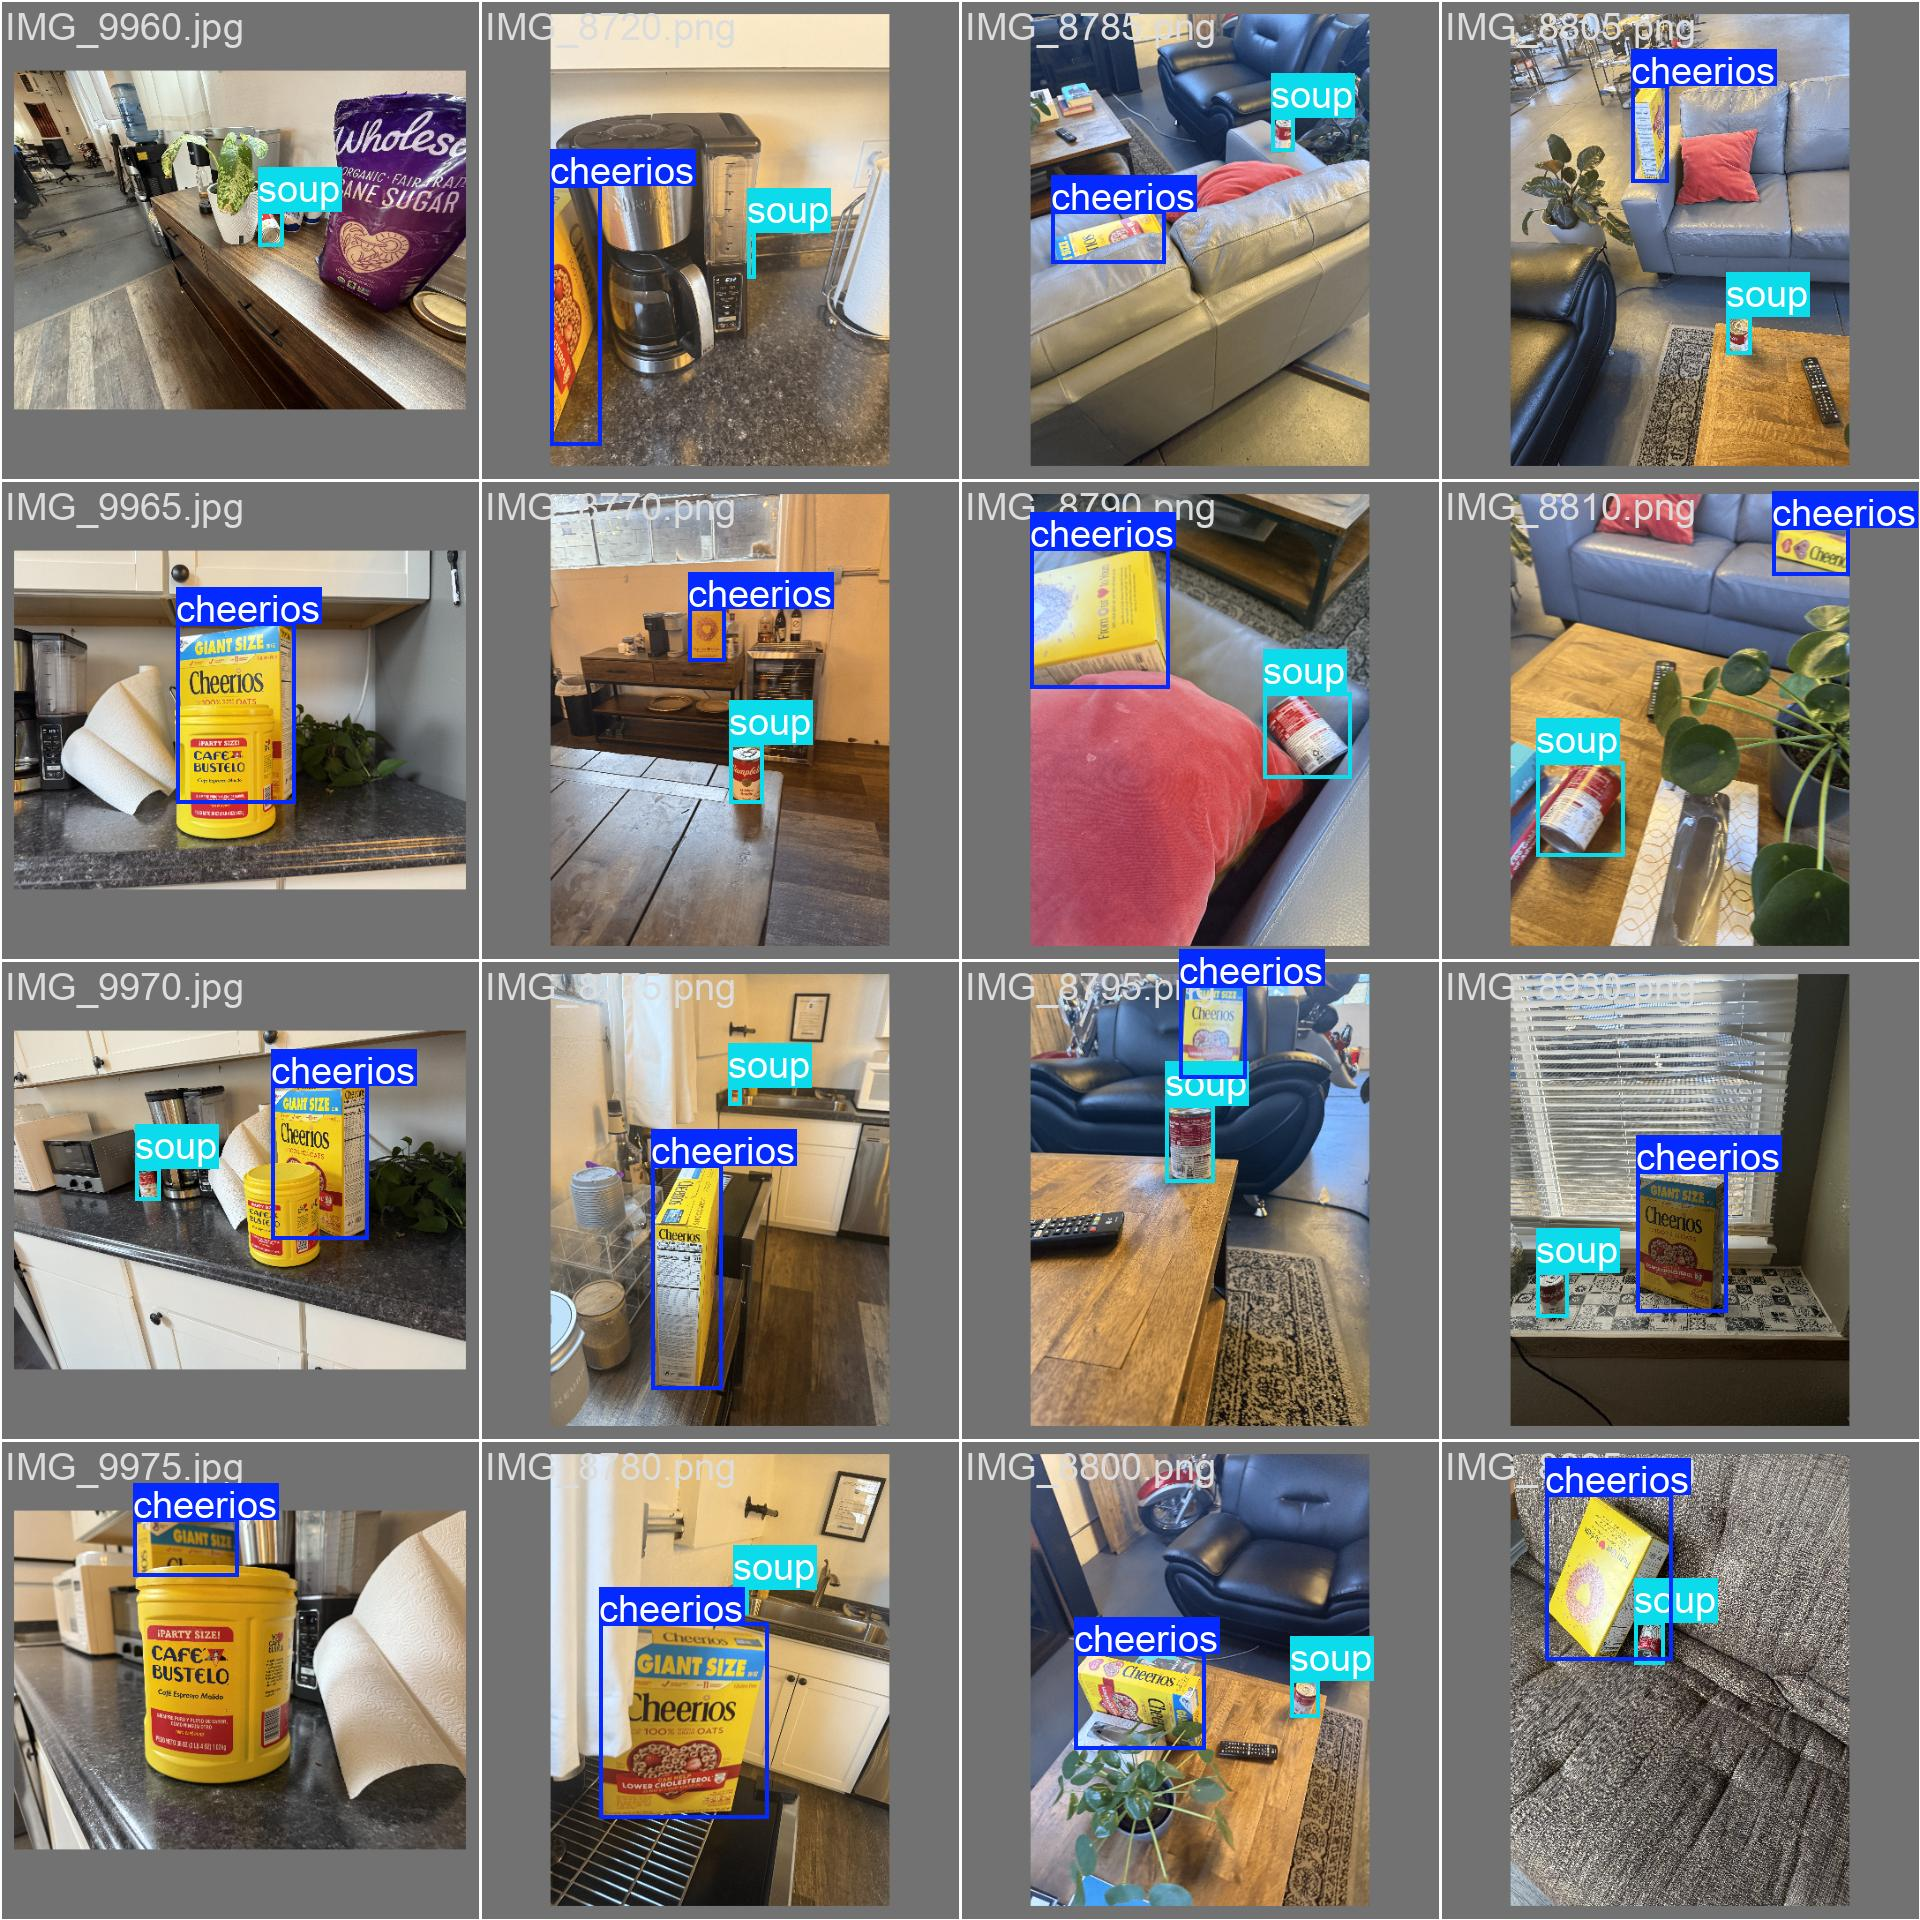

In [27]:
from IPython.display import Image, display

# display(Image(filename='/kaggle/working/train/results.png'))
display(Image(filename='/kaggle/working/runs/detect/val4/val_batch2_labels.jpg'))

In [22]:
num_classes = len(metrics.names)

print(f"mAP-50 score on validation dataset is {metrics.box.map50}")

for i in range(len(metrics.names)):
    p, r, ap50, ap = metrics.box.class_result(i)
    class_name = metrics.names[i]
    print(f"Class {i} ({class_name}): Precision={p:.3f}, Recall={r:.3f}, AP@0.5={ap50:.3f}, AP@.5:.95={ap:.3f}")


mAP-50 score on validation dataset is 0.749769509958929
Class 0 (cheerios): Precision=0.788, Recall=0.682, AP@0.5=0.772, AP@.5:.95=0.486
Class 1 (soup): Precision=0.927, Recall=0.607, AP@0.5=0.728, AP@.5:.95=0.496
